In [1]:
import numpy as np
import pandas as pd
from numba import njit

from math import log, sqrt, exp, erf, ceil

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from time import perf_counter

""" API requirements """
import pandas as pd
import yfinance as yf

""" Plt font size """
plt.rcParams['font.size'] = '15'
plt.rcParams["figure.figsize"] = (20, 7)
plt.style.use('bmh')

""" Force Numpy and Pandas to print floating format with 5 decimal places"""
np.set_printoptions(suppress=True, precision=5)
pd.set_option("display.precision", 5)

# Question 1

------------------------------------------------------------------------------------------------------------------------
## Calculate T
Count how many trading days until 6 months from now and devide by 252

In [2]:
import pandas_market_calendars as mcal
import datetime as dt
# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
# print(mcal.get_calendar_names())
NOW     = dt.datetime.now() # OR 
# NOW     = dt.datetime(year=2023, month=3, day=10)
_END    = NOW+dt.timedelta(days=ceil(365/2))
calendar        = nyse.schedule(start_date=NOW, end_date=_END)
expiration_date = pd.to_datetime(calendar.index.values[-1])

T = calendar.shape[0]

print(f"Expiration Date = {pd.to_datetime(expiration_date).strftime('%Y-%m-%d')}")
print(f"Trading Days until expiration = {T} / 252") ; T = T / 252
print(f"T = {T}")
# early

Expiration Date = 2023-09-07
Trading Days until expiration = 127 / 252
T = 0.503968253968254


## Calculate R

In [3]:
""" Treasury Bill : TMUBMUSD06M 
site: https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD06M
value: 5.148% """

r = 0.05148
R = np.log(1 + r)

print(f"Annualized return = {r}")
print(f'Cont. Comp return = {R:.5f}')

Annualized return = 0.05148
Cont. Comp return = 0.05020


## Calculate S0
### Get Historical Stock Data from Yahoo Finance

In [4]:
aapl = yf.Ticker("AAPL")

In [5]:
""" Get historical market data """
_START  = NOW-dt.timedelta(days=ceil(365/2))
hist    = aapl.history(start=_START, end=NOW)
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-09-06,155.97273,156.59076,153.20157,154.03889,73714800,0.0,0
2022-09-07,154.32798,156.17209,153.12182,155.46436,87449600,0.0,0
2022-09-08,154.14854,155.86307,152.19476,153.96912,84923800,0.0,0
2022-09-09,154.97590,157.31844,154.25819,156.86986,68028800,0.0,0
2022-09-12,159.08281,163.73796,158.79373,162.91060,104956000,0.0,0
...,...,...,...,...,...,...,...
2023-03-01,146.83000,147.23000,145.00999,145.31000,55479000,0.0,0
2023-03-02,144.38000,146.71001,143.89999,145.91000,52238100,0.0,0
2023-03-03,148.03999,151.11000,147.33000,151.03000,70668500,0.0,0


### Calculate S0 from the last Closing Price - daily Interval

In [6]:
""" Closing Price - S0 """
S0 = hist.iloc[-1].Close ; print(f'S0 = {S0:.5f}')

S0 = 151.60001


## Calculate SIGMA - Historical Volatility

Historical Volatility the last 6 months using different methods for calculating Volatility

Std(log(returns)): 
>> 0.022585482

Parkinson volatility: 
>> 0.017933388

Rogers and Satchell Volatility: 
>> 0.017197461


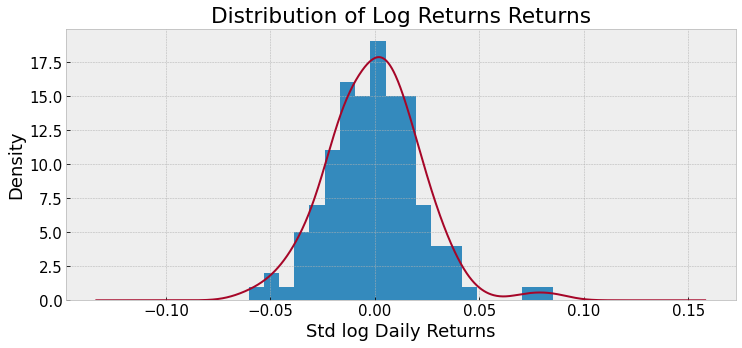

In [7]:
from numpy import log as ln
""" Std of the log of daily returns """
hist['prChange'] = hist.Close.pct_change()
hist['log_ret'] = np.log(1 + hist.prChange)
print("Historical Volatility the last 6 months using different methods for calculating Volatility\n")

""" Std of Log Returns for the last 6 months """
SIGMA = hist.loc[hist.index > _START].log_ret.std(ddof=1)
print(f'Std(log(returns)): \n>> {SIGMA:.9f}\n')

""" Parkinson Volatility Model """
sum_squared_log_HL = ((np.log((hist.High / hist.Low)))**2 ).loc[hist.index > _START]
parkinson_historical_volatility_last_6_months = np.sqrt( 1/(4*(sum_squared_log_HL.shape[0]-1)*np.log(2)) * sum_squared_log_HL.sum() )
print(f'Parkinson volatility: \n>> {parkinson_historical_volatility_last_6_months:.9f}\n')

""" Rogers and Satchell Volatility Function """
data = hist.loc[hist.index > _START]
daily_rs_sqr_vol = (ln(data.High/data.Open)*(ln(data.High/data.Close))) \
         + ln(data.Low/data.Open)*( ln(data.Low/data.Close))
rs_vol = np.sqrt(daily_rs_sqr_vol.mean())
print(f'Rogers and Satchell Volatility: \n>> {rs_vol:.9f}')

ax = hist.loc[hist.index > _START].log_ret.hist(bins=20)
ax = hist.loc[hist.index > _START].log_ret.plot(kind='kde', title='Distribution of Log Returns Returns', figsize=(12,5))
plt.xlabel('Std log Daily Returns') ; plt.show()


## Calculate K

Get available expiration dates for available options' - and find option closer to the current

In [8]:
""" Available Dates """
options_list = aapl.options
print('Available Expiration Dates: ', options_list)

""" Find Nearest to 6 months """
indx_of_closest_to_6M = np.argmin(np.abs(pd.to_datetime(options_list) - _END))
print(f'>>Expiration Date closest to the 6 months: {options_list[indx_of_closest_to_6M]}')

Available Expiration Dates:  ('2023-03-10', '2023-03-17', '2023-03-24', '2023-03-31', '2023-04-06', '2023-04-14', '2023-04-21', '2023-05-19', '2023-06-16', '2023-07-21', '2023-08-18', '2023-09-15', '2023-10-20', '2023-12-15', '2024-01-19', '2024-03-15', '2024-06-21', '2024-09-20', '2025-01-17', '2025-06-20', '2025-12-19')
>>Expiration Date closest to the 6 months: 2023-09-15


In [9]:
""" Put Options ~ 6 Months from now """
opt = aapl.option_chain(options_list[ indx_of_closest_to_6M])
opt_puts = opt.puts
opt_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL230915P00065000,2023-03-07 17:51:17+00:00,65.0,0.11,0.00,0.00,0.0,0.0,5,0,0.25001,False,REGULAR,USD
1,AAPL230915P00070000,2023-03-07 20:00:39+00:00,70.0,0.17,0.00,0.00,0.0,0.0,4,0,0.25001,False,REGULAR,USD
2,AAPL230915P00075000,2023-03-06 17:43:14+00:00,75.0,0.21,0.00,0.00,0.0,0.0,1,0,0.25001,False,REGULAR,USD
3,AAPL230915P00080000,2023-03-07 14:59:44+00:00,80.0,0.28,0.00,0.00,0.0,0.0,25,0,0.12501,False,REGULAR,USD
4,AAPL230915P00085000,2023-03-07 19:23:15+00:00,85.0,0.38,0.00,0.00,0.0,0.0,10,0,0.12501,False,REGULAR,USD
5,AAPL230915P00090000,2023-03-07 20:47:43+00:00,90.0,0.49,0.00,0.00,0.0,0.0,27,0,0.12501,False,REGULAR,USD
6,AAPL230915P00095000,2023-03-07 20:03:02+00:00,95.0,0.68,0.00,0.00,0.0,0.0,4,0,0.12501,False,REGULAR,USD
7,AAPL230915P00100000,2023-03-07 19:46:17+00:00,100.0,0.87,0.00,0.00,0.0,0.0,136,0,0.12501,False,REGULAR,USD
8,AAPL230915P00105000,2023-03-07 20:44:02+00:00,105.0,1.13,0.00,0.00,0.0,0.0,40,0,0.12501,False,REGULAR,USD
9,AAPL230915P00110000,2023-03-07 19:35:59+00:00,110.0,1.52,0.00,0.00,0.0,0.0,10,0,0.12501,False,REGULAR,USD


In [10]:
""" From that list, puts ~ at the money """
_tempdf = opt_puts[opt_puts.inTheMoney == True]
option_at_the_money = _tempdf.iloc[(_tempdf['strike'] - S0 ).abs().argsort()[:1]]

K  = option_at_the_money.strike.iloc[0]
P0 = option_at_the_money.lastPrice.iloc[0]

""" Local Variables for consistency across calculations - Comment out for getting live data"""
S0 = 153.8 #USD 
K  = 155.0 #USD
P0 = 11.2  #USD

""" Return K and P Used """
print(f"S0 = {S0:.1f} USD \nK  = {K} USD")
print(f"P0 = {P0}  USD <-- Asking Price for a put option with these parameters")

option_at_the_money

S0 = 153.8 USD 
K  = 155.0 USD
P0 = 11.2  USD <-- Asking Price for a put option with these parameters


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
18,AAPL230915P00155000,2023-03-07 20:39:35+00:00,155.0,12.36,0.0,0.0,0.0,0.0,104,0,0.00001,True,REGULAR,USD


# Question 2

-------------------------------------------------------------------------------------------------------------------------------
## Black Sholes Analytical Solution

In [11]:
@njit
def bs_put(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    """ negative in front - negative in front of d1 """
    D = - (1.0 + erf(-d1 / sqrt(2.0))) / 2.0
    V = S*D + K*exp(-r*T)* (1.0 + erf(-d2 / sqrt(2.0))) / 2.0

    return V

In [12]:
print(f'S0, K, T, R, SIGMA = {S0:.1f}, {K:.1f}, {T:.3f}, {R:.4f}, {SIGMA:.4f}')
black_sholes_put_value = bs_put(S0, K, T, R, SIGMA)
print("------ BS Put Evaluation ------")
print(f'Option Value with Black-Scholes Formula = {black_sholes_put_value:.5f}')

S0, K, T, R, SIGMA = 153.8, 155.0, 0.504, 0.0502, 0.0226
------ BS Put Evaluation ------
Option Value with Black-Scholes Formula = 0.17003


## Binomial Tree - Option Valuation

In [13]:
@njit
def option_valuation_bt(S0, K, T, r, sigma, N, type="Call", american=False, print_tree=False):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt)) 
    d = np.exp(-sigma * np.sqrt(dt)) 
    p = (np.exp(r*dt) - d)/(u - d) 
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            tree[i, j] = S0 * d ** (i-j) * u ** (j) 
    if print_tree: print(np.rot90(tree)) 

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    """ Back Propagation: we start in last row of the matrix """

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows-1, c] = max(0, _S - K) 
        else: tree[rows-1, c] = max(0, K- _S) 
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "Call":
                if american:    tree[i , j ] = max(tree[i , j ]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) 
                else:           tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) 
            else:
                if american:    tree[i , j ] = max(K-tree[i , j ], (np.exp(-r*dt)) * (p * up + (1 - p) * down)) 
                else:           tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) 
    if print_tree: print(np.rot90(tree))
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S0 * (u - d))
    return V

In [14]:
N = 1_000

P_bt = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=N, type="Put", american=True)
print(f'Option Value with N({N}) steps = {P_bt:.5f}')
# print(f'Delta with N({N}) steps        = {Delta_bt:.5f}')

Option Value with N(1000) steps = 1.20000


## Calculate/Plot Option Value Convergence with N (steps)

In [15]:
NN = 10_000 ;   size = 100
values = np.zeros((size, 3))

for n in tqdm(np.append(np.logspace(1, np.log10(NN), size, base=10, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    P_bt = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=n, type="Put")
    values[size-1] = n, P_bt, perf_counter() - _st
    size -= 1
values = values[::-1]

  0%|          | 0/101 [00:00<?, ?it/s]

,Binary Tree,Execution Time,Black Scholes,|Difference|
10,0.13030,2.30000e-05,0.17003,0.03973
11,0.14099,6.66600e-06,0.17003,0.02904
12,0.13393,5.50000e-06,0.17003,0.03610
13,0.14682,5.16700e-06,0.17003,0.02321
14,0.13615,5.95800e-06,0.17003,0.03388
...,...,...,...,...
7564,0.16997,3.70386e-01,0.17003,0.00006
8111,0.16999,4.21128e-01,0.17003,0.00004
8697,0.16998,4.91416e-01,0.17003,0.00005
9326,0.17000,5.51896e-01,0.17003,0.00003


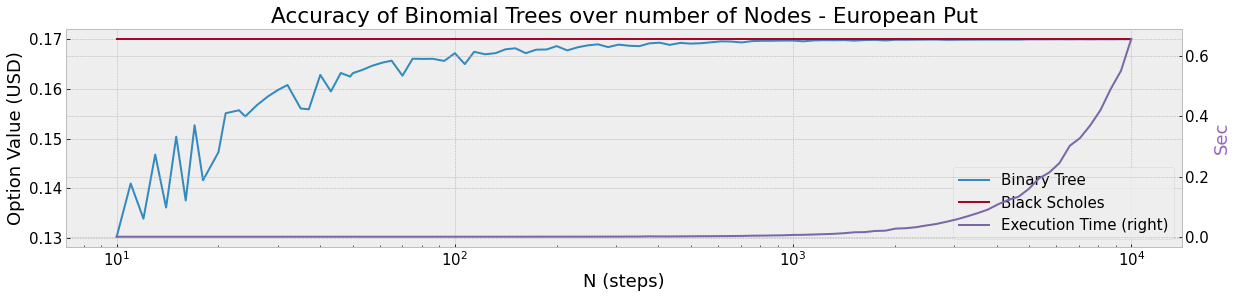

In [16]:

_results_convergence_df = pd.DataFrame(values[:, 1:], columns=['Binary Tree', 'Execution Time'] , index=values[:, 0].astype(int)).sort_index()
_results_convergence_df["Black Scholes"] = black_sholes_put_value
_results_convergence_df["|Difference|"] = abs(_results_convergence_df[['Binary Tree']] - black_sholes_put_value)

ax = _results_convergence_df[['Binary Tree', 'Black Scholes', 'Execution Time']].plot(figsize=(20,4), xlabel='N (steps)', ylabel='Option Value (USD)', mark_right=True,
                              title='Accuracy of Binomial Trees over number of Nodes - European Put', grid=True, logx=True,
                              secondary_y='Execution Time' )
ax.right_ax.set_ylabel('Sec', color='tab:purple')
_results_convergence_df

# Question 3

----------------------------------------------------------------------------------------------------------------

## (a) Print 3 step Binomial Tree - American and European

In [17]:
N = 3
print(" American 3-step Binomial Tree")
_ = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=N, type="Put", american=True,  print_tree=True)

print("\n European 3-step Binomial Tree")
_ = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=N, type="Put", american=False,  print_tree=True)

 American 3-step Binomial Tree
[[  0.        0.        0.      158.13104]
 [  0.        0.      156.67398 155.23034]
 [  0.      155.23034 153.8     152.38284]
 [153.8     152.38284 150.97874 149.58758]]
[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.05344 1.2     2.61716]
 [1.2     2.61716 4.02126 5.41242]]

 European 3-step Binomial Tree
[[  0.        0.        0.      158.13104]
 [  0.        0.      156.67398 155.23034]
 [  0.      155.23034 153.8     152.38284]
 [153.8     152.38284 150.97874 149.58758]]
[[0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.      0.00519 0.11655 2.61716]
 [0.01522 0.23149 2.71966 5.41242]]


## (a) Plot Relative to Time - American vs European

  0%|          | 0/100 [00:00<?, ?it/s]

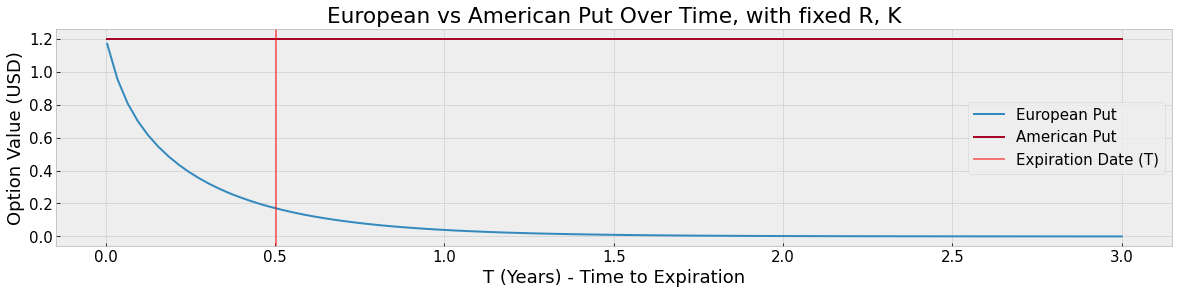

In [18]:
N = 1_000   ;   size = 100  ;   values = np.zeros((size, 3))
for _T in tqdm(np.linspace(1/252, 3, num=size)):
    _P_bt_european = option_valuation_bt(S0=S0, K=K, T=_T, r=R, sigma=SIGMA, N=N, type="Put")
    _P_bt_american = option_valuation_bt(S0=S0, K=K, T=_T, r=R, sigma=SIGMA, N=N, type="Put", american=True)
    values[size-1] = [_T, _P_bt_european, _P_bt_american]
    size -= 1

_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df

axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='T (Years) - Time to Expiration', ylabel='Option Value (USD)',
                              title='European vs American Put Over Time, with fixed R, K', grid=True)
axs.axvline(T, color='r', linestyle='-', alpha=.5, label='Expiration Date (T)') ;   axs.legend() ; plt.show()

## (b) Plot Option Value Relative to N - American vs European

  0%|          | 0/200 [00:00<?, ?it/s]

American vs European put
Rel Difference: 1.03
 %  Difference: 605.90 %


European Put    0.17
American Put    1.20
Difference      1.03
Name: 10000.0, dtype: float64

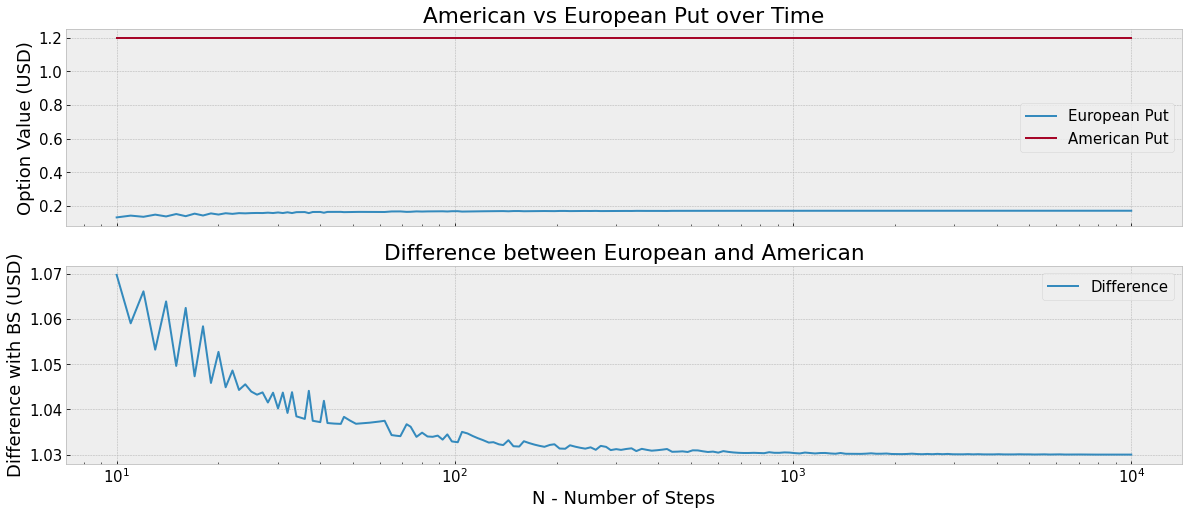

In [19]:
size = 200  ;   values = np.zeros((size, 3))
for n in tqdm(np.logspace(1, 4, num=size, base=10, dtype=int)):
    _P_bt_european = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=n, type="Put")
    _P_bt_american = option_valuation_bt(S0=S0, K=K, T=T, r=R, sigma=SIGMA, N=n, type="Put", american=True)
    values[size-1] = [n, _P_bt_european, _P_bt_american]
    size -= 1

""" Plot """
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df["Difference"] = _results_df[['American Put']].to_numpy() - _results_df[['European Put']].to_numpy()

fig, axs = plt.subplots(2, sharex=True)

_results_df[['European Put', 'American Put']].plot(figsize=(20,8), xlabel='N', ylabel='Option Value (USD)', ax=axs[0],
                              title='American vs European Put over Time', grid=True, logx=True)
_results_df[["Difference"]].plot(figsize=(20,8), xlabel='N - Number of Steps', ylabel='Difference with BS (USD)',  ax=axs[1],
                              title='Difference between European and American', grid=True, logx=True, logy=False)
print('American vs European put')
print(f'Rel Difference: {(_results_df.iloc[-1,1] - _results_df.iloc[-1,0]):.2f}')
print(f' %  Difference: {(_results_df.iloc[-1,1] - _results_df.iloc[-1,0]) / _results_df.iloc[-1,0] *100:.2f} %')
_results_df.iloc[-1]

## (c) Effect of Interest Rates to American and European Puts

Annualized Interest Rate: 5.148%


  0%|          | 0/100 [00:00<?, ?it/s]

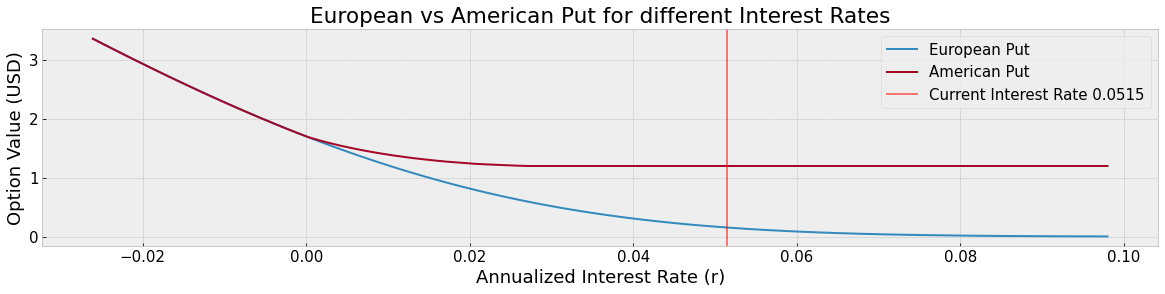

In [20]:
print(f'Annualized Interest Rate: {r*100:.3f}%')
N = 100
size = 100  ;   values = np.zeros((size, 3))
for _r in tqdm(np.linspace(-r/2, r*2, num=size)): 
    _r = np.log(1+ _r) # From annual to CCIR
    _V_bt_european = option_valuation_bt(S0=S0, K=K, T=T, r=_r, sigma=SIGMA, N=N, type="P")
    _V_bt_american = option_valuation_bt(S0=S0, K=K, T=T, r=_r, sigma=SIGMA, N=N, type="P", american=True)
    values[size-1] = [_r, _V_bt_european, _V_bt_american]
    size -= 1

""" Plot """
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='Annualized Interest Rate (r)', ylabel='Option Value (USD)',title='European vs American Put for different Interest Rates', grid=True)
axs.axvline(r, color='r', linestyle='-', alpha=.5, label=f'Current Interest Rate {r:.4f}') ;   axs.legend() ; plt.show()

# Question 4

---------------------------------------------------------------------------------------------------------------------------------
## Calculate Implied Volatility - Using Newton's Method

In [21]:
""" Choice Number of Steps """
print('-------- Number of nodes for estimating American Option Value --------')
print(_results_convergence_df[_results_convergence_df.index > 1000].index.values)

-------- Number of nodes for estimating American Option Value --------
[ 1072  1149  1232  1321  1417  1519  1629  1747  1873  2009  2154  2310
  2477  2656  2848  3053  3274  3511  3764  4037  4328  4641  4977  5336
  5722  6135  6579  7054  7564  8111  8697  9326 10000]


In [22]:
N = 5336
Approximation_Error = abs(_results_convergence_df[_results_convergence_df.index == N][["|Difference|"]].values[0,0])
Approximation_Error

6.081944671468276e-05

## Newtons Mehtod

In [23]:
it_max = 30         # Maximum Iterations to be performed for finding the best approximation for IV
ds = 0.02           # Step in sigma to make to estimate the slope
s0 = .5             # Set initial guess to something high so the convergence is easier, compared to when using small initial guess for IV.
print(f"Initial s0 = {s0:.5f}\nCorrect Option Value = {P0}")

_V  = option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0, N=N, type="Put", american=True) 
fx  = abs(P0 - _V) ;   _iv_convergence = np.array([[s0, fx]])
print(f"difference in P0 estimation = {fx:.5f}")

_st = perf_counter() ; it = 1
while it < 30:
    """ step 1: calculate new Option Values with bumped volatility """
    f_x_plus_ds   = abs(P0 - option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0+ds, N=N, type="Put", american=True))
    print(f'---------------- iteration {it} --------------------')

    """ step 2: Calculate slope (a) based on second derivative finate difference """
    fprime  = (f_x_plus_ds - fx) / ds # First Finate Derivative Forward in space
    s0 = s0 - fx / fprime             # Frist order Newtons Method

    print(f's0 = {s0:.5f}')
    _V = option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=s0, N=N, type="Put", american=True)
    fx = abs(P0 - _V) ; print(f"difference in P0 estimation = {fx:.5f}")
    _iv_convergence = np.append(_iv_convergence, [[s0, fx]], axis=0)
    print(f'Value: {_V:.5f}')

    if abs(fx) < 1e-6: break
    it += 1
    
print(f">>Time to Calculate = {perf_counter() - _st:.7f}")
IV = s0

Initial s0 = 0.50000
Correct Option Value = 11.2
difference in P0 estimation = 9.29273
---------------- iteration 1 --------------------
s0 = 0.28091
difference in P0 estimation = 0.03144
Value: 11.16856
---------------- iteration 2 --------------------
s0 = 0.28011
difference in P0 estimation = 0.06538
Value: 11.13462
---------------- iteration 3 --------------------
s0 = 0.27830
difference in P0 estimation = 0.14259
Value: 11.05741
---------------- iteration 4 --------------------
s0 = 0.27326
difference in P0 estimation = 0.35691
Value: 10.84309
---------------- iteration 5 --------------------
s0 = 0.22138
difference in P0 estimation = 2.56147
Value: 8.63853
---------------- iteration 6 --------------------
s0 = 0.28172
difference in P0 estimation = 0.00332
Value: 11.20332
---------------- iteration 7 --------------------
s0 = 0.28165
difference in P0 estimation = 0.00000
Value: 11.20000
>>Time to Calculate = 2.3893025


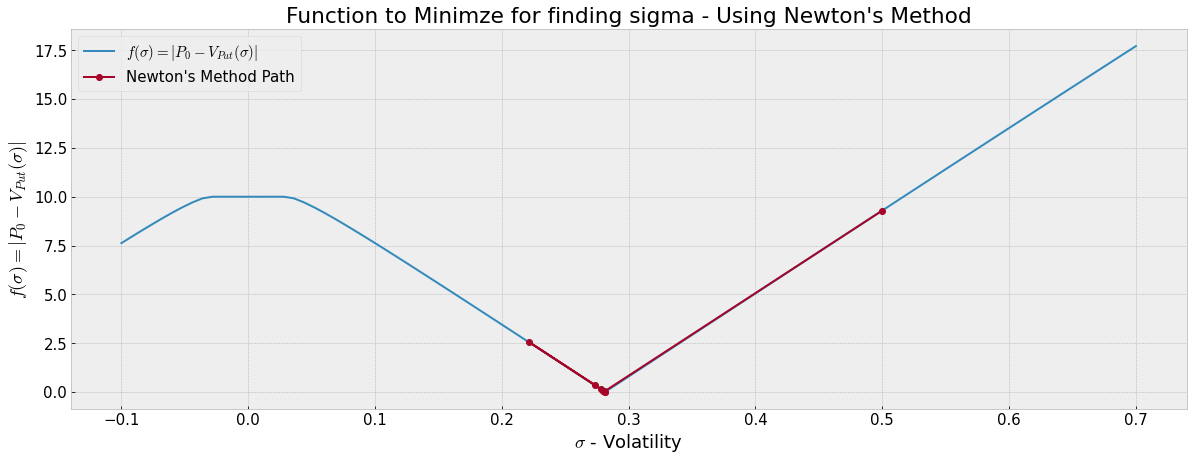

Implied Volatility = 0.28165  vs  Historical Volatility = 0.02259    
Difference = 1147.025 %  
>>> Iterations = 7


,IV,abs(Market Price - Estimation)
Iteration,,
1,0.50000,9.29273e+00
2,0.28091,3.14406e-02
3,0.28011,6.53783e-02
4,0.27830,1.42593e-01
5,0.27326,3.56908e-01
6,0.22138,2.56147e+00
7,0.28172,3.31548e-03
8,0.28165,8.73119e-07


In [24]:
s = np.linspace(-.1,.7,101)
v = [abs(P0 - option_valuation_bt(S0=S0, K=K, T=T, r=r, sigma=_, N=100, type="Put", american=True)) for _ in s]
plt.plot(s,v) ; plt.xlabel(r'$\sigma$ - Volatility') ; plt.ylabel(r'$f(\sigma)=|P_0 - V_{Put}(\sigma)|$') ; plt.title("Function to Minimze for finding sigma - Using Newton's Method")
plt.plot(_iv_convergence[:,0], _iv_convergence[:,1], marker='o')
plt.legend([r'$f(\sigma)=|P_0 - V_{Put}(\sigma)|$', "Newton's Method Path"])
plt.show()

print(f'Implied Volatility = {IV:.5f}  vs  '
      f'Historical Volatility = {SIGMA:.5f}    \n'
      f'Difference = {(IV - SIGMA)/SIGMA * 100 :.3f} %  \n'
      f'>>> Iterations = {it}')

""" Implied volatility Optimization History """
_df = pd.DataFrame(_iv_convergence, columns=['IV', 'abs(Market Price - Estimation)'], index=range(1,_iv_convergence.shape[0]+1)) ; _df.index.name = 'Iteration'
_df